In [33]:
!pip install tsai

In [34]:
import pandas as pd 
import numpy as np 
from collections import Counter 
import matplotlib.pyplot as plt
from tsai.all import *

In [35]:
class ArrayGenerator:
    import numpy as np
    
    dataset_categories = {
        1: "motor",
        2: "bearing",
        3: "flow",
        4: "lxc",
        5: "mixed",
        6: "coupling",
        7: "all",
        8: "status"
    }
    
    dataset_descriptions = {
        1: {"Faults classified": "AirGap, Electrical and SoftFoot problems", "Channels taken": "Motor channels only", "Labels array": "Binary"},
        2: {"Faults classified": "BearingFault, BearingWear, BearingLubrication", "Channels taken": "According to label", "Labels array": "Binary"},
        3: {"Faults classified": "Flow problem", "Channels taken": "Machine channels only", "Labels array": "Binary"},
        4: {"Faults classified": "LXC, XC, Losseness", "Channels taken": "All", "Labels array": "Binary"},
        5: {"Faults classified": "LXC, Unbalance, BaseProblems", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        6: {"Faults classified": "Coupling problems", "Channels taken": "Drive end channels only", "Labels array": "Binary"},
        7: {"Faults classified": "All", "Channels taken": "All", "Labels array": "multiclass multilabel"},
        8: {"Faults classified": "Status", "Channels taken": "All", "Labels array": "multiclass"}
    }
    
    def separate_data(self, ts, labels, split_method):
        _, num_channels, num_points = ts.shape
        
        if split_method == "channel":
            new_ts = ts.reshape(-1, 1, num_points)
            new_labels = np.repeat(labels, repeats=num_channels, axis=0)
        
        elif split_method == "bearing":
            new_ts = ts.reshape(-1, 3, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 3, axis=0)
        
        elif split_method == "machine":
            new_ts = ts.reshape(-1, 6, num_points)
            new_labels = np.repeat(labels, repeats=num_channels // 6, axis=0)
        
        elif split_method == "None":  # Changed from None to "None"
            new_ts = ts
            new_labels = np.array(labels)
        
        else:
            raise Exception("Invalid split type: choose from [channel, bearing, machine, None]")
        
        return new_ts, new_labels
    
    def generate_dataset_array(self, dataset_category, ts, labels, split_method):
        if dataset_category == 1: 
            faults = ["AirGap", "SoftFoot", "ElectricalProblem"]
            new_labels = [1 if any(motor_fault in fault for fault in faults_list for motor_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, :6, :]

        elif dataset_category == 2:
            faults = ["BearingFault", "BearingWear", "BearingLubrication"]
            new_labels = np.zeros((len(labels), 2))
    
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    if any(bearing_fault == fault_name for bearing_fault in faults):
                        if fault_location == "motor":
                            new_labels[major_index][0] = 1
                        else:
                            new_labels[major_index][1] = 1
                            
            new_ts_1 = ts[:, :6, :]
            new_labels_1 = new_labels[:, 0]
    
            new_ts_2 = ts[:, 6:, :]
            new_labels_2 = new_labels[:, 1]
            
            new_labels = np.concatenate([new_labels_1, new_labels_2], axis=0)
            new_ts = np.concatenate([new_ts_1, new_ts_2], axis=0)

        elif dataset_category == 3:
            faults = ["Flow"]
            new_labels = [1 if any(flow_fault in fault for fault in faults_list for flow_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 6:, :]

        elif dataset_category == 4:
            faults = ["LXC", "Looseness", "XC"]
            new_labels = [1 if any(lxc_fault in fault for fault in faults_list for lxc_fault in faults) else 0 for faults_list in labels]
            new_ts = ts

        elif dataset_category == 5:
            faults_and_indices = {
                0: ["LXC", "Looseness", "XC"],
                1: ["BaseProblems"],
                2: ["Unbalance"]
            }

            new_labels = np.zeros((len(labels), 3))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_names in faults_and_indices.items():
                        if fault_name in fault_names:
                            new_labels[major_index][index] = 1
            new_ts = ts

        elif dataset_category == 6:
            faults = ["Coupling", "BeltProblem"]
            new_labels = [1 if any(coupling_fault in fault for fault in faults_list for coupling_fault in faults) else 0 for faults_list in labels]
            new_ts = ts[:, 3:9, :]

        elif dataset_category == 7:
            faults_and_indices = {
                0: ["AirGap", "SoftFoot", "ElectricalProblem"],
                1: ["BearingFault", "BearingWear", "BearingLubrication"],
                2: ["flow"],
                3: ["LXC", "Looseness", "XC"],
                4: ["BaseProblems"],
                5: ["Unbalance"],
                6: ["Coupling", "BeltProblem"]
            }

            new_labels = np.zeros((len(labels), 7))
            for major_index, faults_list in enumerate(labels):
                for fault in faults_list:
                    fault_name, fault_location = fault.split(',')
                    for index, fault_cluster in faults_and_indices.items():
                        if fault_name in fault_cluster:
                            new_labels[major_index][index] = 1

            new_ts = ts

        elif dataset_category == 8:
            if type(labels[0]) == list:
                raise Exception("Invalid labels for category 8")
            new_ts = ts
            new_labels = labels

        else:
            raise Exception("Invalid dataset category, choose from [1, 2, 3, 4, 5, 6, 7]")

        print(self.dataset_descriptions[dataset_category])
        return self.separate_data(ts=new_ts, labels=new_labels, split_method=split_method)
    
    def calculate_fft(self, signal):
        signal = signal * np.hanning(len(signal))  # Apply hanning window
        fft = np.fft.fft(signal)
        fft = np.abs(fft)  # Take absolute value
        fft = fft[: len(fft) // 2]  # Take the first half only
        return fft

    def apply_sliding_window(self, ts_3d, labels, window_size=4096, with_fft=False, overlap_pct=0.0):
        
        x_new = []
        y_new = []
    
        
        for ts, label in zip(ts_3d, labels):
            ts = ts[:, ~np.any(np.isnan(ts), axis=0)] #Remove columns with NaN values
            """np.isnan(ts) checks for NaN (Not a Number) values in the ts array.
                np.any(..., axis=0) checks if any of the values in each column is NaN.
                 ~ negates the boolean array, so ~np.any(...) keeps only the columns where there are no NaN values."""
            num_channels, signal_length = ts.shape #Get the number of channels and signal length
            overlap = int(window_size * overlap_pct)
            stride = window_size - overlap
            num_windows = (signal_length - window_size) // stride + 1
            
            
            print(f"Num windows: {num_windows}, Num channels: {num_channels}, Window size: {window_size}")

            
            if with_fft:
                fft_window_size = window_size if window_size % 2 == 0 else window_size + 1
                print(f"FFT Window size: {fft_window_size}")
                x_temp = np.zeros((num_windows, num_channels, window_size // 2))
            else:
                x_temp = np.zeros((num_windows, num_channels, window_size))

            y_temp = []

            for i in range(num_windows):
                start = i * stride
                end = start + window_size
                
                if with_fft:
                    x_temp[i] = np.apply_along_axis(self.calculate_fft, arr=ts[:, start:end], axis=1)
                else:
                    x_temp[i] = ts[:, start:end]
                    
                y_temp.append(label)

            x_new.append(x_temp)
            y_new.append(y_temp)

        x_new, y_new = np.concatenate(x_new), np.concatenate(y_new)

        return x_new, y_new


In [36]:
df = pd.read_pickle(r"/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle")
df.head(1)

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans,ts
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)","[[-0.01095184, -0.011836081, -0.012565245, -0.012270509, -0.012300278, -0.013320656, -0.013026895, -0.012533905, -0.013063409, -0.012450588, -0.011686881, -0.012133516, -0.011509651, -0.011013504, -0.01114404, -0.010445369, -0.009850427, -0.01007186, -0.009217497, -0.008727451, -0.008961891, -0.008416777, -0.007894184, -0.008172687, -0.008083154, -0.007089157, -0.006830435, -0.006774916, -0.005936872, -0.005677863, -0.005666965, -0.004578024, -0.004122706, -0.003228867, -0.001870759, -0.001284106, -0.000899825, 0.000474368, 0.000831867, 0.001056994, 0.002552633, 0.003245881, 0.002865068, 0..."


In [37]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])
X.shape, y.shape

((217, 12, 16384), (217,))

In [38]:
# Instantiate ArrayGenerator
array_gen = ArrayGenerator()

# Call generate_dataset_array method on the instance
X, y = array_gen.generate_dataset_array(dataset_category=1, ts=X, labels=y, split_method="channel")


{'Faults classified': 'AirGap, Electrical and SoftFoot problems', 'Channels taken': 'Motor channels only', 'Labels array': 'Binary'}


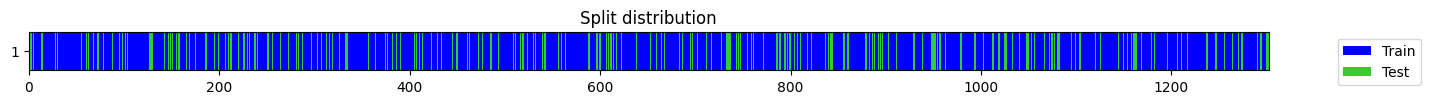

In [39]:
report_splits = get_splits(y, valid_size=0.2, shuffle=True)

In [40]:
X_train, y_train = X[report_splits[0]], y[report_splits[0]]
X_test, y_test = X[report_splits[1]], y[report_splits[1]]

In [41]:
array_gen = ArrayGenerator()
X_train, y_train = array_gen.apply_sliding_window(ts_3d=X_train, labels=y_train, window_size=4096, with_fft=True, overlap_pct=0.8)
X_test, y_test = array_gen.apply_sliding_window(ts_3d=X_test, labels=y_test, window_size=4096, with_fft=True, overlap_pct=0.0)


Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096
FFT Window size: 4096
Num windows: 5, Num channels: 1, Window size: 4096


valid == train


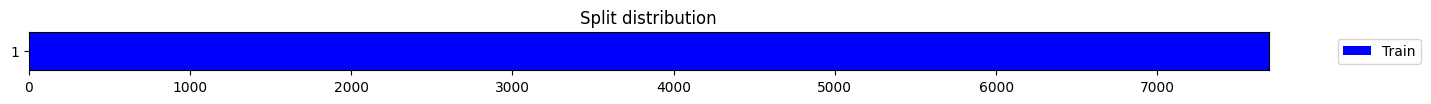

Counter({1: 6105, 0: 6105})

In [42]:
train_balance_splits = get_splits(y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [43]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test]) 

In [44]:
tfms  = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[32,256])

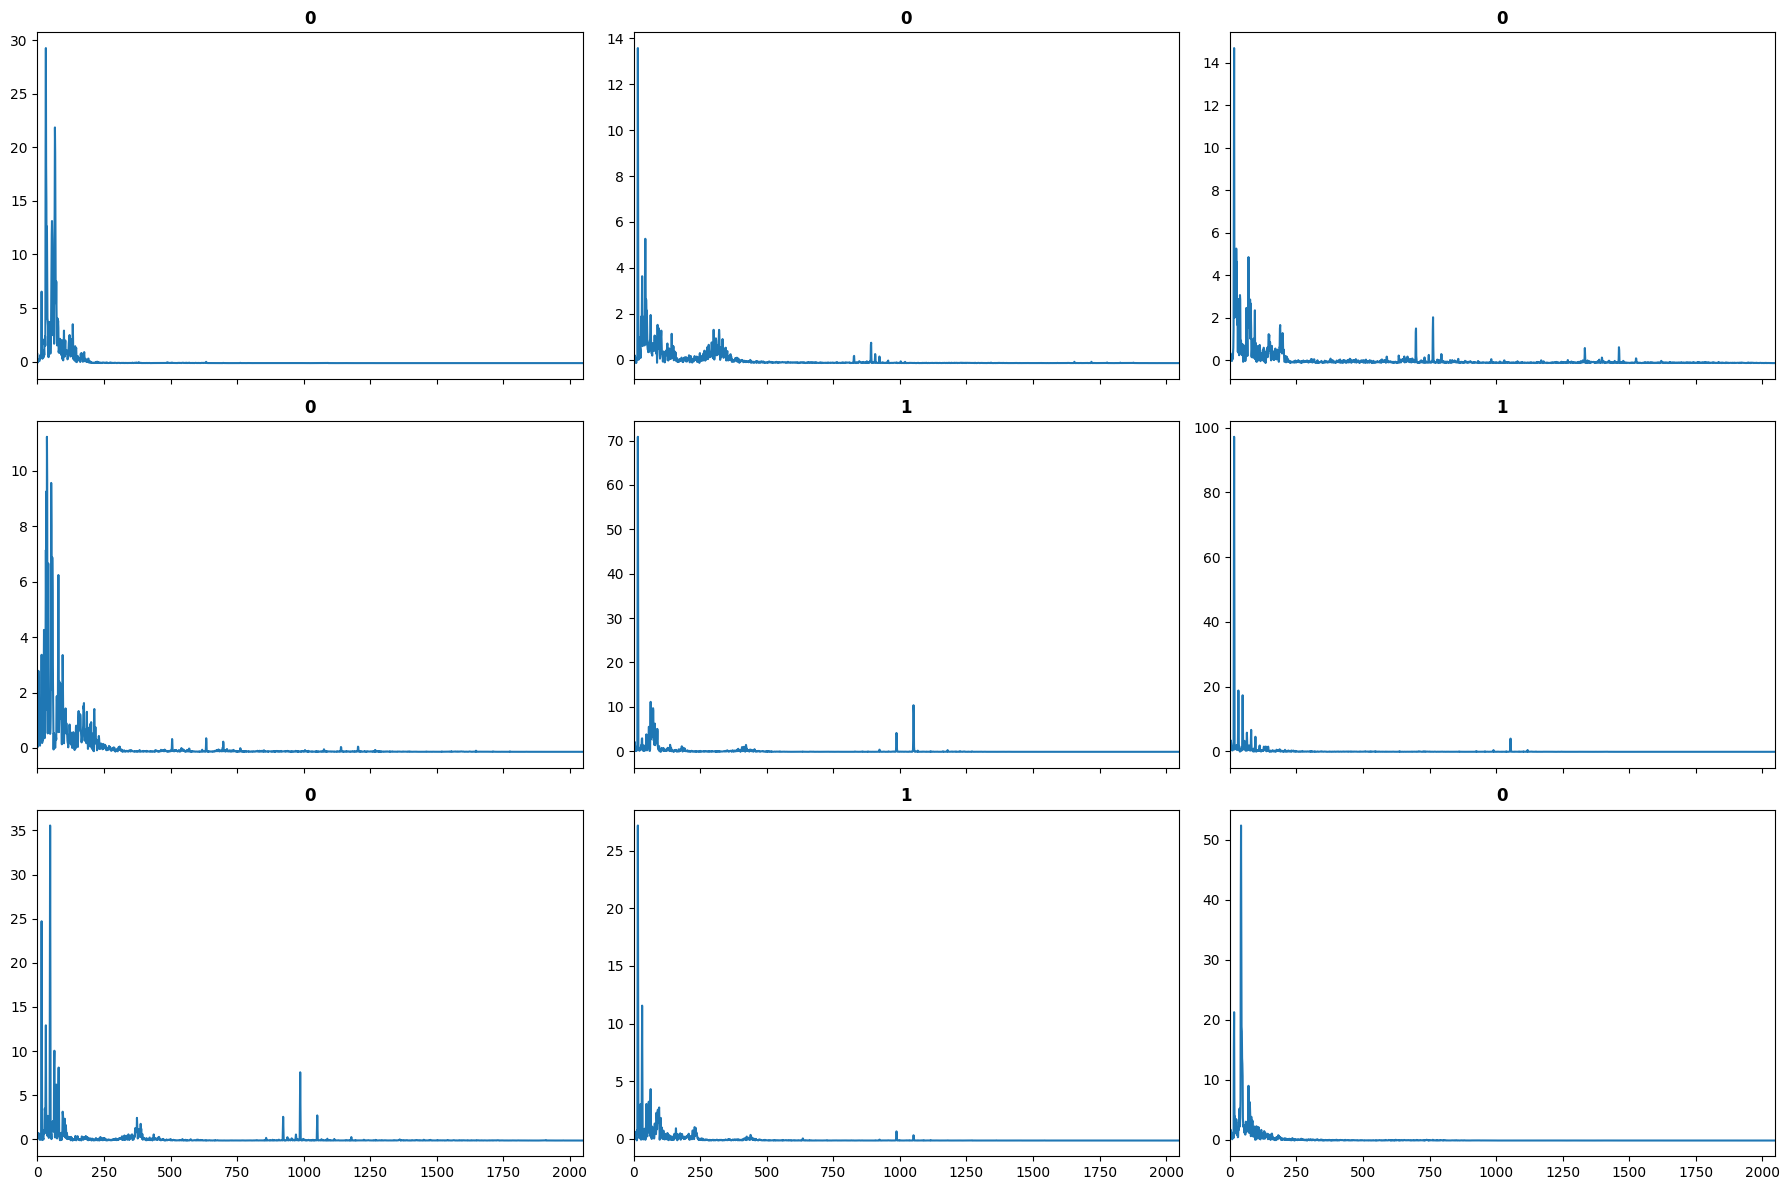

In [45]:
dls.show_batch(sharex=True) 

In [46]:
model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.176103,0.332378,0.887821,0.706731,0.942308,0.807692,0.905983,00:02
1,0.081838,0.234367,0.910256,0.774725,0.903846,0.834320,0.908120,00:01
2,0.046488,0.223859,0.918269,0.793296,0.910256,0.847761,0.915598,00:01
3,0.025798,0.222353,0.935897,0.825843,0.942308,0.880240,0.938034,00:02
4,0.014662,0.210991,0.924679,0.804469,0.923077,0.859701,0.924145,00:02
5,0.009541,0.205253,0.935897,0.825843,0.942308,0.880240,0.938034,00:02


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
5,0.009541,0.205253,0.935897,0.825843,0.942308,0.88024,0.938034


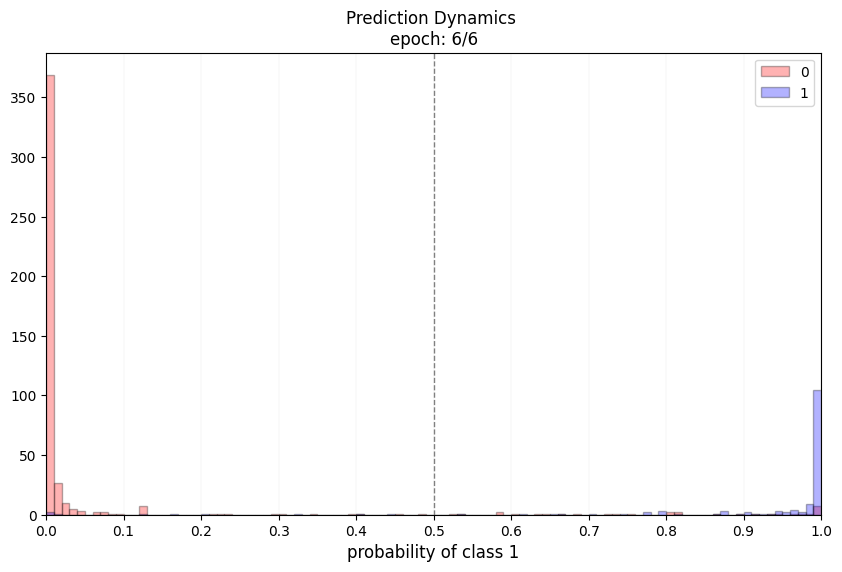

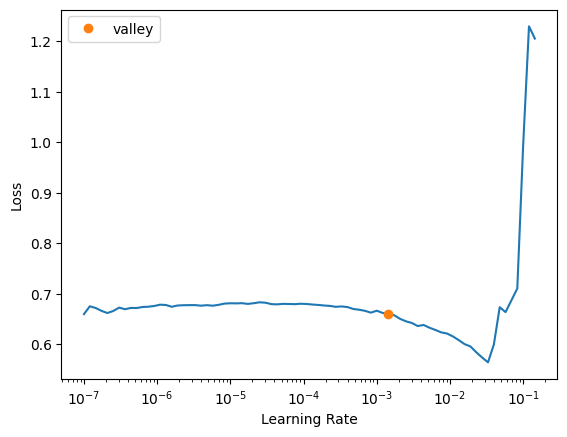

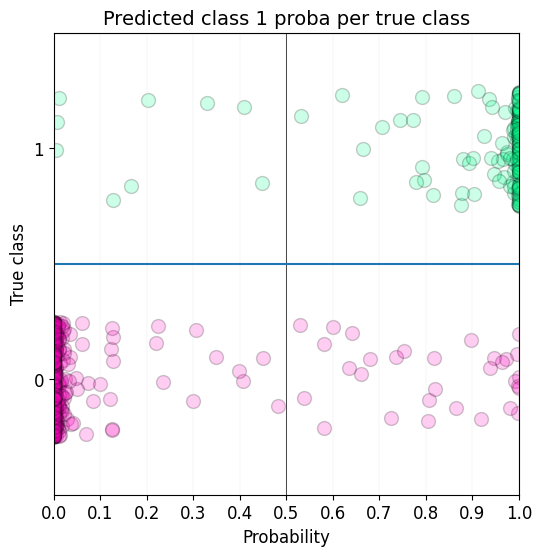

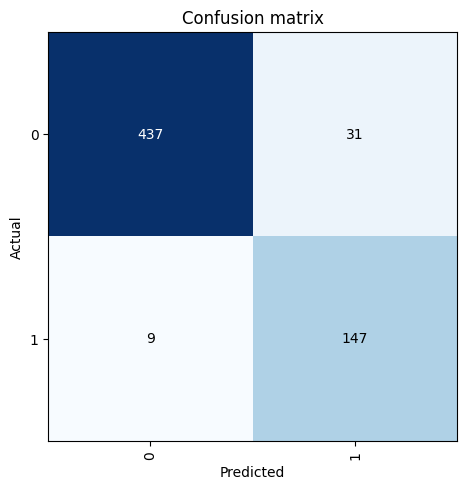

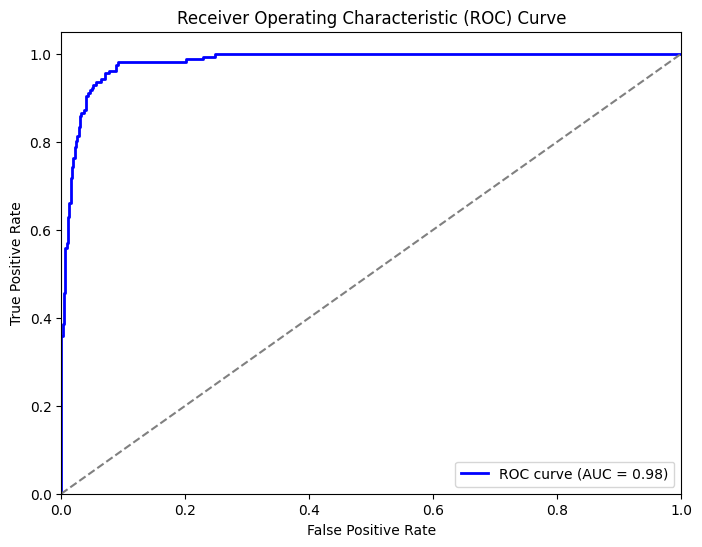

In [47]:
learn.fit_one_cycle(6, lr_max=learn.lr_find(), cbs=[PredictionDynamics()]) 
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
#Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [48]:
!pip install optuna-integration

In [ ]:
from fastai.callback.all import EarlyStoppingCallback
import optuna
from optuna.integration import FastAIPruningCallback
import optuna.integration

num_epochs = 8
num_optuna_trials = 40

# Get the input shape from the training data
seq_len = X_train.shape[-1]

def objective(trial: optuna.Trial):
    # Define search space here.
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    model = MLP(dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True)
    learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()])
    learn.fit_one_cycle(num_epochs, lr_max=learn.lr_find(), cbs=[EarlyStoppingCallback(patience=7)])

    # Return the validation loss - learn.recorder.values returns [[train_loss, valid_loss, metrics...]]
    return learn.recorder.values[-1][1]

study = optuna.create_study(
    direction="minimize", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)


[I 2024-04-18 11:07:04,171] A new study created in memory with name: no-name-ad7039bd-3926-4a01-90d3-a00a4e808af6


  0%|          | 0/40 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.189944,0.245402,0.913462,0.800000,0.871795,0.834356,0.899573,00:02
1,0.111053,0.222281,0.916667,0.779570,0.929487,0.847953,0.920940,00:02
2,0.073358,0.177736,0.940705,0.840000,0.942308,0.888218,0.941239,00:01
3,0.036702,0.151911,0.934295,0.836257,0.916667,0.874618,0.928419,00:01
4,0.022926,0.138818,0.945513,0.867470,0.923077,0.894410,0.938034,00:01
5,0.013576,0.181178,0.948718,0.878049,0.923077,0.900000,0.940171,00:02
6,0.005226,0.167499,0.950321,0.849162,0.974359,0.907463,0.958333,00:02
7,0.004787,0.171358,0.953526,0.862857,0.967949,0.912387,0.958333,00:02


[I 2024-04-18 11:07:20,983] Trial 0 finished with value: 0.17135758697986603 and parameters: {'hidden_size': 64, 'dropout_rate': 0.8814332543978504}. Best is trial 0 with value: 0.17135758697986603.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.282970,0.327371,0.883013,0.710660,0.897436,0.793201,0.887821,00:01
1,0.114029,0.293491,0.907051,0.752577,0.935897,0.834286,0.916667,00:01
2,0.063713,0.203068,0.932692,0.847561,0.891026,0.868750,0.918803,00:01
3,0.029939,0.248039,0.932692,0.820225,0.935897,0.874251,0.933761,00:01
4,0.017903,0.152210,0.942308,0.833333,0.961538,0.892857,0.948718,00:01
5,0.015676,0.177657,0.945513,0.863095,0.929487,0.895062,0.940171,00:01
6,0.009632,0.223498,0.940705,0.840000,0.942308,0.888218,0.941239,00:01
7,0.009341,0.182839,0.945513,0.854651,0.942308,0.896341,0.944444,00:02


[I 2024-04-18 11:07:37,382] Trial 1 finished with value: 0.18283873796463013 and parameters: {'hidden_size': 64, 'dropout_rate': 0.9271958816998425}. Best is trial 0 with value: 0.17135758697986603.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.245700,0.300274,0.895833,0.728643,0.929487,0.816901,0.907051,00:01
1,0.086557,0.213123,0.911859,0.758974,0.948718,0.843305,0.924145,00:01
2,0.052144,0.211490,0.942308,0.852941,0.929487,0.889571,0.938034,00:01
3,0.026582,0.199535,0.934295,0.828571,0.929487,0.876133,0.932692,00:01
4,0.019048,0.176661,0.945513,0.871951,0.916667,0.893750,0.935897,00:02
5,0.011275,0.130747,0.958333,0.891566,0.948718,0.919255,0.955128,00:01
6,0.007124,0.141655,0.948718,0.856322,0.955128,0.903030,0.950855,00:02
7,0.007824,0.113543,0.958333,0.882353,0.961538,0.920245,0.959402,00:02


[I 2024-04-18 11:07:53,946] Trial 2 finished with value: 0.11354333907365799 and parameters: {'hidden_size': 128, 'dropout_rate': 0.36253490661216425}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.279391,0.359111,0.884615,0.698113,0.948718,0.804348,0.905983,00:01
1,0.100120,0.268069,0.905449,0.746193,0.942308,0.832861,0.917735,00:02
2,0.058079,0.165030,0.929487,0.818182,0.923077,0.867470,0.927350,00:01
3,0.037944,0.210744,0.924679,0.794595,0.942308,0.862170,0.930556,00:01
4,0.020460,0.131233,0.939103,0.839080,0.935897,0.884848,0.938034,00:01
5,0.015283,0.134111,0.937500,0.867925,0.884615,0.876190,0.919872,00:01
6,0.012256,0.154412,0.945513,0.876543,0.910256,0.893082,0.933761,00:02
7,0.008372,0.116877,0.955128,0.876471,0.955128,0.914110,0.955128,00:01


[I 2024-04-18 11:08:10,306] Trial 3 finished with value: 0.11687742173671722 and parameters: {'hidden_size': 16, 'dropout_rate': 0.8176833371803557}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.243400,0.314597,0.884615,0.703883,0.929487,0.801105,0.899573,00:01
1,0.100149,0.244967,0.911859,0.772973,0.916667,0.838710,0.913462,00:01
2,0.055580,0.196806,0.921474,0.795580,0.923077,0.854599,0.922009,00:02
3,0.031898,0.196746,0.923077,0.829268,0.871795,0.850000,0.905983,00:01
4,0.019929,0.193917,0.943910,0.906040,0.865385,0.885246,0.917735,00:01
5,0.013071,0.158221,0.945513,0.867470,0.923077,0.894410,0.938034,00:02
6,0.007785,0.157086,0.945513,0.858824,0.935897,0.895706,0.942308,00:02
7,0.007830,0.182557,0.951923,0.870588,0.948718,0.907975,0.950855,00:01


[I 2024-04-18 11:08:26,874] Trial 4 finished with value: 0.18255695700645447 and parameters: {'hidden_size': 16, 'dropout_rate': 0.03745404913489481}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.329799,0.394148,0.870192,0.669683,0.948718,0.785146,0.896368,00:01
1,0.128252,0.297806,0.892628,0.719212,0.935897,0.813370,0.907051,00:02
2,0.070615,0.186645,0.929487,0.825581,0.910256,0.865854,0.923077,00:01
3,0.040870,0.206134,0.927885,0.800000,0.948718,0.868035,0.934829,00:01
4,0.026686,0.145658,0.934295,0.844311,0.903846,0.873065,0.924145,00:02
5,0.017012,0.152630,0.935897,0.829545,0.935897,0.879518,0.935897,00:02
6,0.016705,0.158276,0.935897,0.829545,0.935897,0.879518,0.935897,00:01
7,0.015510,0.145472,0.942308,0.857143,0.923077,0.888889,0.935897,00:01


[I 2024-04-18 11:08:43,318] Trial 5 finished with value: 0.14547201991081238 and parameters: {'hidden_size': 16, 'dropout_rate': 0.4502272934265167}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.306216,0.418189,0.865385,0.668224,0.916667,0.772973,0.882479,00:01
1,0.113719,0.250478,0.895833,0.726368,0.935897,0.817927,0.909188,00:01
2,0.049642,0.247701,0.919872,0.794444,0.916667,0.851190,0.918803,00:01
3,0.031004,0.258972,0.923077,0.793478,0.935897,0.858824,0.927350,00:01
4,0.022547,0.241581,0.916667,0.776596,0.935897,0.848837,0.923077,00:01
5,0.019855,0.152982,0.945513,0.891026,0.891026,0.891026,0.927350,00:02
6,0.015190,0.172557,0.932692,0.827586,0.923077,0.872727,0.929487,00:01
7,0.014387,0.162690,0.940705,0.869565,0.897436,0.883281,0.926282,00:01


[I 2024-04-18 11:08:59,782] Trial 6 finished with value: 0.16268987953662872 and parameters: {'hidden_size': 128, 'dropout_rate': 0.9256702929874808}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.250100,0.330142,0.886218,0.699531,0.955128,0.807588,0.909188,00:01
1,0.096951,0.255759,0.905449,0.762162,0.903846,0.826979,0.904915,00:01
2,0.063472,0.192685,0.931090,0.826590,0.916667,0.869301,0.926282,00:01
3,0.037020,0.273345,0.910256,0.742718,0.980769,0.845304,0.933761,00:01
4,0.017484,0.174888,0.942308,0.875000,0.897436,0.886076,0.927350,00:01
5,0.015688,0.170551,0.935897,0.849398,0.903846,0.875776,0.925214,00:01
6,0.008312,0.184640,0.943910,0.871166,0.910256,0.890282,0.932692,00:01
7,0.008383,0.175536,0.947115,0.855491,0.948718,0.899696,0.947650,00:01


[I 2024-04-18 11:09:15,962] Trial 7 finished with value: 0.17553596198558807 and parameters: {'hidden_size': 32, 'dropout_rate': 0.8277977839582081}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.188534,0.300596,0.891026,0.726804,0.903846,0.805714,0.895299,00:01
1,0.098324,0.207476,0.911859,0.775956,0.910256,0.837758,0.911325,00:01
2,0.077046,0.206973,0.927885,0.810056,0.929487,0.865672,0.928419,00:01
3,0.030442,0.159255,0.950321,0.893082,0.910256,0.901587,0.936966,00:02
4,0.019715,0.258608,0.919872,0.781915,0.942308,0.854651,0.927350,00:02
5,0.012595,0.198050,0.939103,0.859756,0.903846,0.881250,0.927350,00:01
6,0.006669,0.168450,0.939103,0.851190,0.916667,0.882716,0.931624,00:01
7,0.005944,0.161468,0.939103,0.847059,0.923077,0.883436,0.933761,00:01


[I 2024-04-18 11:09:32,730] Trial 8 finished with value: 0.16146814823150635 and parameters: {'hidden_size': 16, 'dropout_rate': 0.04056419791934518}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.255308,0.296169,0.887821,0.717172,0.910256,0.802260,0.895299,00:02
1,0.086596,0.200863,0.926282,0.831325,0.884615,0.857143,0.912393,00:01
2,0.056436,0.285157,0.905449,0.762162,0.903846,0.826979,0.904915,00:02
3,0.040666,0.184165,0.932692,0.816667,0.942308,0.875000,0.935897,00:01
4,0.020484,0.192913,0.932692,0.813187,0.948718,0.875740,0.938034,00:01
5,0.012700,0.179008,0.929487,0.814607,0.929487,0.868263,0.929487,00:01
6,0.009325,0.191675,0.940705,0.869565,0.897436,0.883281,0.926282,00:02
7,0.007262,0.184517,0.951923,0.884146,0.929487,0.906250,0.944444,00:01


[I 2024-04-18 11:09:49,500] Trial 9 finished with value: 0.18451730906963348 and parameters: {'hidden_size': 128, 'dropout_rate': 0.24820201497778716}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.346369,0.369523,0.863782,0.671498,0.891026,0.765840,0.872863,00:02
1,0.128584,0.248527,0.902244,0.754011,0.903846,0.822157,0.902778,00:02
2,0.071570,0.190260,0.918269,0.777778,0.942308,0.852174,0.926282,00:01
3,0.043059,0.171755,0.926282,0.805556,0.929487,0.863095,0.927350,00:02
4,0.028721,0.178225,0.932692,0.813187,0.948718,0.875740,0.938034,00:01
5,0.023407,0.171228,0.929487,0.821839,0.916667,0.866667,0.925214,00:01
6,0.017017,0.185503,0.932692,0.813187,0.948718,0.875740,0.938034,00:02
7,0.015907,0.183457,0.926282,0.795699,0.948718,0.865497,0.933761,00:01


[I 2024-04-18 11:10:06,065] Trial 10 finished with value: 0.18345719575881958 and parameters: {'hidden_size': 128, 'dropout_rate': 0.5882801647171012}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.269659,0.386352,0.866987,0.660793,0.961538,0.783290,0.898504,00:01
1,0.107935,0.281780,0.902244,0.748691,0.916667,0.824207,0.907051,00:01
2,0.057039,0.171519,0.940705,0.874214,0.891026,0.882540,0.924145,00:01
3,0.027654,0.224369,0.932692,0.813187,0.948718,0.875740,0.938034,00:02
4,0.028584,0.173592,0.942308,0.865854,0.910256,0.887500,0.931624,00:02
5,0.015612,0.174388,0.948718,0.864706,0.942308,0.901840,0.946581,00:01
6,0.012866,0.209886,0.931090,0.812155,0.942308,0.872404,0.934829,00:01
7,0.013122,0.167804,0.945513,0.867470,0.923077,0.894410,0.938034,00:01


[I 2024-04-18 11:10:22,593] Trial 11 finished with value: 0.1678040623664856 and parameters: {'hidden_size': 32, 'dropout_rate': 0.6186123541475121}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.253413,0.393512,0.865385,0.669811,0.910256,0.771739,0.880342,00:01
1,0.106576,0.271983,0.902244,0.756757,0.897436,0.821114,0.900641,00:02
2,0.055099,0.225997,0.926282,0.831325,0.884615,0.857143,0.912393,00:02
3,0.031068,0.200589,0.939103,0.855422,0.910256,0.881988,0.929487,00:02
4,0.023816,0.196697,0.927885,0.836364,0.884615,0.859813,0.913462,00:01
5,0.009587,0.175181,0.939103,0.835227,0.942308,0.885542,0.940171,00:01
6,0.008059,0.134452,0.947115,0.886792,0.903846,0.895238,0.932692,00:01
7,0.005820,0.159675,0.948718,0.887500,0.910256,0.898734,0.935897,00:01


[I 2024-04-18 11:10:39,079] Trial 12 finished with value: 0.1596745401620865 and parameters: {'hidden_size': 16, 'dropout_rate': 0.37614333639393105}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.308246,0.375225,0.863782,0.666667,0.910256,0.769648,0.879274,00:02
1,0.115638,0.212407,0.918269,0.774869,0.948718,0.853026,0.928419,00:01
2,0.062404,0.217647,0.919872,0.781915,0.942308,0.854651,0.927350,00:01
3,0.036867,0.246199,0.915064,0.784530,0.910256,0.842730,0.913462,00:02
4,0.024473,0.220682,0.923077,0.796703,0.929487,0.857988,0.925214,00:01
5,0.014201,0.185467,0.937500,0.834286,0.935897,0.882175,0.936966,00:01
6,0.012979,0.208512,0.934295,0.817680,0.948718,0.878338,0.939103,00:02
7,0.011474,0.206371,0.927885,0.800000,0.948718,0.868035,0.934829,00:01


[I 2024-04-18 11:10:55,493] Trial 13 finished with value: 0.2063712626695633 and parameters: {'hidden_size': 128, 'dropout_rate': 0.7071930505761693}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.219658,0.317329,0.892628,0.719212,0.935897,0.813370,0.907051,00:02
1,0.072949,0.219461,0.905449,0.759358,0.910256,0.827988,0.907051,00:01
2,0.048177,0.205992,0.927885,0.813559,0.923077,0.864865,0.926282,00:02
3,0.031553,0.162684,0.931090,0.838323,0.897436,0.866873,0.919872,00:02
4,0.015178,0.243928,0.926282,0.808989,0.923077,0.862275,0.925214,00:02
5,0.009018,0.191795,0.942308,0.870370,0.903846,0.886792,0.929487,00:01
6,0.009541,0.146565,0.947115,0.872727,0.923077,0.897196,0.939103,00:02
7,0.006436,0.150891,0.942308,0.852941,0.929487,0.889571,0.938034,00:02


[I 2024-04-18 11:11:12,393] Trial 14 finished with value: 0.15089111030101776 and parameters: {'hidden_size': 16, 'dropout_rate': 0.2232840180986767}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.379574,0.452455,0.807692,0.572581,0.910256,0.702970,0.841880,00:01
1,0.146241,0.252013,0.908654,0.767568,0.910256,0.832845,0.909188,00:02
2,0.075417,0.237070,0.916667,0.782609,0.923077,0.847059,0.918803,00:01
3,0.052286,0.212408,0.927885,0.806630,0.935897,0.866469,0.930556,00:01
4,0.034173,0.169774,0.934295,0.828571,0.929487,0.876133,0.932692,00:01
5,0.026671,0.173258,0.934295,0.821229,0.942308,0.877612,0.936966,00:01
6,0.024800,0.164316,0.934295,0.814208,0.955128,0.879056,0.941239,00:02
7,0.021002,0.166793,0.929487,0.814607,0.929487,0.868263,0.929487,00:01


[I 2024-04-18 11:11:28,858] Trial 15 finished with value: 0.16679252684116364 and parameters: {'hidden_size': 128, 'dropout_rate': 0.7446708719373569}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.280616,0.334533,0.884615,0.707921,0.916667,0.798883,0.895299,00:01
1,0.110933,0.245875,0.892628,0.721393,0.929487,0.812325,0.904915,00:02
2,0.050498,0.232764,0.908654,0.767568,0.910256,0.832845,0.909188,00:02
3,0.032497,0.205933,0.916667,0.792135,0.903846,0.844311,0.912393,00:02
4,0.026507,0.197711,0.931090,0.792746,0.980769,0.876791,0.947650,00:01
5,0.017843,0.173929,0.934295,0.810811,0.961538,0.879765,0.943376,00:01
6,0.012453,0.176481,0.931090,0.815642,0.935897,0.871642,0.932692,00:02
7,0.010691,0.178451,0.937500,0.834286,0.935897,0.882175,0.936966,00:01


[I 2024-04-18 11:11:45,607] Trial 16 finished with value: 0.1784510463476181 and parameters: {'hidden_size': 32, 'dropout_rate': 0.33242061545875934}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.207379,0.299320,0.892628,0.723618,0.923077,0.811268,0.902778,00:01
1,0.097349,0.276477,0.916667,0.770833,0.948718,0.850575,0.927350,00:01
2,0.073514,0.256327,0.907051,0.772222,0.891026,0.827381,0.901709,00:01
3,0.037751,0.223412,0.921474,0.795580,0.923077,0.854599,0.922009,00:01
4,0.023823,0.224052,0.921474,0.792350,0.929487,0.855457,0.924145,00:01
5,0.012852,0.221222,0.939103,0.835227,0.942308,0.885542,0.940171,00:01
6,0.007171,0.188099,0.935897,0.825843,0.942308,0.880240,0.938034,00:01
7,0.006722,0.208547,0.931090,0.826590,0.916667,0.869301,0.926282,00:01


[I 2024-04-18 11:12:01,944] Trial 17 finished with value: 0.20854651927947998 and parameters: {'hidden_size': 64, 'dropout_rate': 0.5154452963750344}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.223439,0.293204,0.884615,0.707921,0.916667,0.798883,0.895299,00:01
1,0.102794,0.213874,0.921474,0.816568,0.884615,0.849231,0.909188,00:01
2,0.052535,0.220833,0.918269,0.796610,0.903846,0.846847,0.913462,00:01
3,0.035921,0.205857,0.921474,0.809249,0.897436,0.851064,0.913462,00:01
4,0.022827,0.189286,0.937500,0.838150,0.929487,0.881459,0.934829,00:01
5,0.009752,0.164647,0.942308,0.844828,0.942308,0.890909,0.942308,00:01
6,0.010082,0.172335,0.951923,0.888889,0.923077,0.905660,0.942308,00:01
7,0.007831,0.136104,0.947115,0.872727,0.923077,0.897196,0.939103,00:01


[I 2024-04-18 11:12:18,071] Trial 18 finished with value: 0.13610416650772095 and parameters: {'hidden_size': 16, 'dropout_rate': 0.16788525549167532}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.242903,0.286467,0.883013,0.700483,0.929487,0.798898,0.898504,00:01
1,0.117682,0.261010,0.894231,0.736842,0.897436,0.809249,0.895299,00:01
2,0.058405,0.206205,0.913462,0.777174,0.916667,0.841176,0.914530,00:01
3,0.038954,0.225289,0.924679,0.797814,0.935897,0.861357,0.928419,00:02
4,0.017643,0.171064,0.937500,0.826816,0.948718,0.883582,0.941239,00:02
5,0.013994,0.183188,0.943910,0.841808,0.955128,0.894895,0.947650,00:02
6,0.010403,0.163549,0.945513,0.876543,0.910256,0.893082,0.933761,00:02
7,0.008226,0.170165,0.942308,0.852941,0.929487,0.889571,0.938034,00:01


[I 2024-04-18 11:12:34,531] Trial 19 finished with value: 0.17016468942165375 and parameters: {'hidden_size': 128, 'dropout_rate': 0.7535564610245926}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.391641,0.445036,0.838141,0.627907,0.865385,0.727763,0.847222,00:02
1,0.161421,0.247956,0.895833,0.748634,0.878205,0.808260,0.889957,00:01
2,0.092286,0.202178,0.916667,0.788889,0.910256,0.845238,0.914530,00:02
3,0.059078,0.221753,0.921474,0.795580,0.923077,0.854599,0.922009,00:02
4,0.040521,0.185496,0.934295,0.821229,0.942308,0.877612,0.936966,00:01
5,0.029322,0.197162,0.927885,0.803279,0.942308,0.867257,0.932692,00:02
6,0.028322,0.191580,0.927885,0.813559,0.923077,0.864865,0.926282,00:01
7,0.034263,0.178368,0.931090,0.819209,0.929487,0.870871,0.930556,00:01


[I 2024-04-18 11:12:51,193] Trial 20 finished with value: 0.17836841940879822 and parameters: {'hidden_size': 128, 'dropout_rate': 0.481705953832288}. Best is trial 2 with value: 0.11354333907365799.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.335195,0.378052,0.873397,0.687805,0.903846,0.781163,0.883547,00:01
1,0.123928,0.304275,0.878205,0.692308,0.923077,0.791209,0.893162,00:01
2,0.069075,0.191258,0.924679,0.815029,0.903846,0.857143,0.917735,00:02
3,0.037242,0.164966,0.931090,0.838323,0.897436,0.866873,0.919872,00:01
4,0.031108,0.221582,0.932692,0.809783,0.955128,0.876471,0.940171,00:01
5,0.020090,0.223158,0.934295,0.817680,0.948718,0.878338,0.939103,00:01
6,0.014721,0.209123,0.931090,0.812155,0.942308,0.872404,0.934829,00:01
7,0.016502,0.199071,0.929487,0.811111,0.935897,0.869048,0.931624,00:02


[I 2024-04-18 11:13:07,714] Trial 21 finished with value: 0.19907116889953613 and parameters: {'hidden_size': 16, 'dropout_rate': 0.20105439441058792}. Best is trial 2 with value: 0.11354333907365799.
